# ドローン画像を用いた草本の表現型定量

## ライセンス
- 論文　https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.6861
    - CC-BY 4.0
- 公式レポジトリ https://github.com/oceam/WEIPS
    - MIT
- 本稿プログラムコード
    - CC-BY-NC

# 実行コード

In [101]:
import numpy as np
import geopandas as gpd

import rasterio
from rasterio.transform import from_bounds
import scipy.io
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [76]:
# Load the shapefile and TIFF image
shapefile = gpd.read_file("assets/WEIPS/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m/meta/field1plot.shp")

# Load DSM and RGB(A) image
with rasterio.open('assets/WEIPS/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m/image/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m_dsm.tif') as tif_image:
    dsm = tif_image.read(1)
    # extents = tif_image.bounds
    transform = from_bounds(*tif_image.bounds, tif_image.width, tif_image.height)
with rasterio.open('assets/WEIPS/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m/image/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m_transparent_mosaic_group1.tif') as tif_image:
    rgba = tif_image.read().transpose(1,2,0)

In [168]:
shapefile.geometry.bounds

0     POLYGON ((367908.214 3955465.214, 367906.645 3...
1     POLYGON ((367909.743 3955465.498, 367908.173 3...
2     POLYGON ((367911.260 3955465.775, 367909.690 3...
3     POLYGON ((367908.015 3955466.142, 367906.446 3...
4     POLYGON ((367912.782 3955466.103, 367911.213 3...
                            ...                        
85    POLYGON ((367913.830 3955475.820, 367912.260 3...
86    POLYGON ((367918.823 3955475.576, 367917.254 3...
87    POLYGON ((367915.380 3955476.079, 367913.810 3...
88    POLYGON ((367916.985 3955476.433, 367915.416 3...
89    POLYGON ((367918.554 3955476.798, 367916.984 3...
Name: geometry, Length: 90, dtype: geometry

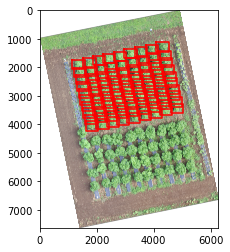

In [169]:
def convert_to_pixel_coords(bounding_box, transform):
    y1, x1 = rasterio.transform.rowcol(transform, bounding_box[0], bounding_box[1])
    y2, x2 = rasterio.transform.rowcol(transform, bounding_box[2], bounding_box[3])
    if y1 > y2:
        y1, y2 = y2, y1
    if x1 > x2:
        x1, x2 = x2, x1
    return x1, y1, x2, y2

# Pre-convert all bounding boxes to pixel coordinates
# 厳密に回転したポリゴンを取得したい場合はshapefile.geometryから計算する。boundsは外接矩形であることに注意。
# 今回は外接矩形でも（さほど）解析に影響がないので、bounds使用する。
# ただし、論文の実装とは異なる結果となることに注意。
bboxes = shapefile.geometry.bounds.apply(lambda x: convert_to_pixel_coords(x, transform), axis=1)

plt.imshow(rgba)
for idx, bbox in enumerate(bboxes):
    x1, y1, x2, y2 = bbox
    plt.plot([x1, x2, x2, x1, x1],
                [y1, y1, y2, y2, y1],
                color='red')

In [119]:
matlab_a = -11.0368
a_thresh = ((matlab_a + 128) / 255) * 255
a_thresh = int(a_thresh)
print(a_thresh)

116


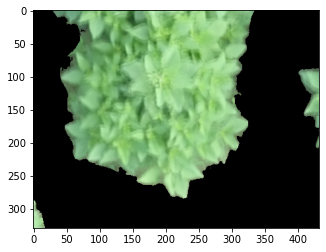

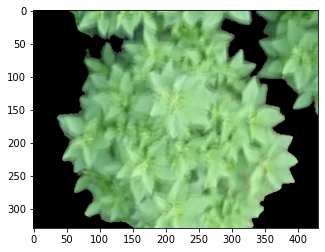

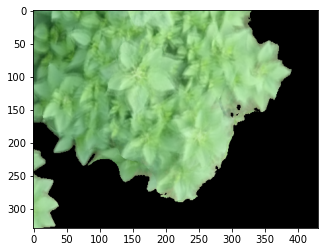

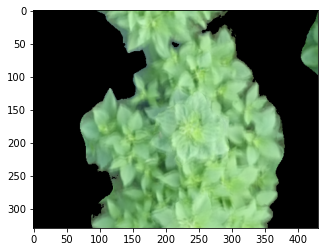

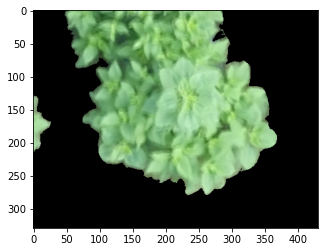

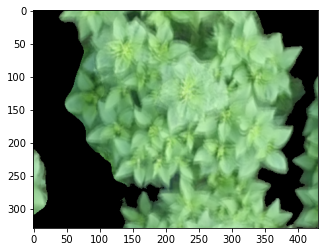

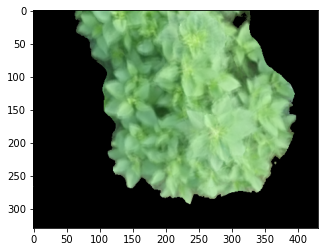

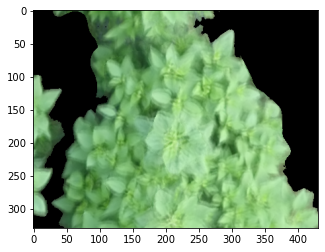

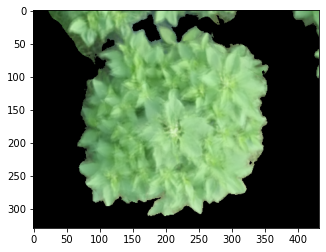

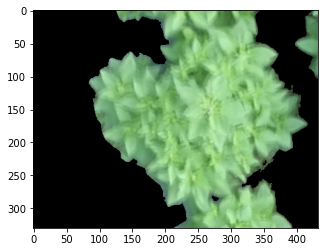

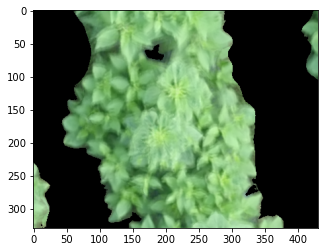

In [179]:
from skimage.color import rgb2lab
import cv2
import math

for idx, bbox in enumerate(bboxes):
    x1, y1, x2, y2 = bbox
    
    # height cutoff first
    dsm_cropped = dsm[y1:y2, x1:x2]
    idx_n0 = np.where(dsm_cropped != 0)
    th_1 = np.ptp(dsm_cropped[idx_n0])  # ptp computes the range (difference between max and min)
    th = dsm_cropped[idx_n0].min() + th_1 * 0.4
    dsm_mask = dsm_cropped > th
    
    rgb = rgba[..., :3].copy()
    plant = rgb[y1:y2, x1:x2, :]
    plant = plant.astype(np.uint8)
    # plant_a_space = rgb2lab(plant)[...,1]
    plant_a_space = cv2.cvtColor(plant, cv2.COLOR_RGB2LAB)[...,1]
    lab_mask = plant_a_space < a_thresh
    
    combined_mask = np.logical_and(dsm_mask, lab_mask)
    
    # use opencv bitwise to mask plant by combined_mask
    plant = cv2.bitwise_and(plant, plant, mask=combined_mask.astype(np.uint8))
    plt.imshow(plant)
    plt.show()
    if idx == 10:
        break
    
    # plt.subplot(1,2,1)
    # plt.imshow(binary)
    # plt.subplot(1,2,2)
    # plt.imshow(plant)
    # break

```matlab
>> view(DTSMmodel)

分類の決定木
1  A1<-11.0368 の場合はノード 2、A1>=-11.0368 の場合はノード 3、それ以外の場合は background
2  class = vegetation
3  class = background

```
